In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# 쓸데없는 warning 끄기
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
root = '/Users/13579/Desktop/Git/TIL/Data Science/data/pubg/'
wrangled = pd.read_csv(root + 'train.csv')

### Drop row with NaN value for winPlacePerc

In [4]:
wrangled.drop(2744604, inplace=True)

### Anomaly

In [5]:
# 움직이지 않고 킬 한 경우
wrangled['killsWithoutMoving'] = (wrangled['kills'] > 0) & (wrangled['walkDistance'] == 0)
wrangled = wrangled.drop(wrangled[wrangled['killsWithoutMoving']==True].index)
wrangled = wrangled.drop(columns=['killsWithoutMoving'])

In [6]:
# Drop columns with 'flare' or'crash' or 'normal' matchtype
wrangled = wrangled[wrangled.matchType!='flarefpp']
wrangled = wrangled[wrangled.matchType!='flaretpp']
wrangled = wrangled[wrangled.matchType!='crashfpp']
wrangled = wrangled[wrangled.matchType!='crashtpp']
wrangled = wrangled[wrangled.matchType!='normal-squad-fpp']
wrangled = wrangled[wrangled.matchType!='normal-duo-fpp']
wrangled = wrangled[wrangled.matchType!='normal-solo-fpp']
wrangled = wrangled[wrangled.matchType!='normal-squad']
wrangled = wrangled[wrangled.matchType!='normal-duo']
wrangled = wrangled[wrangled.matchType!='normal-solo']

### Group

In [7]:
# 팀원 수
wrangled = wrangled.merge(wrangled.groupby(['groupId']).size().to_frame('players_in_team'), how='left', on=['groupId'])

In [8]:
# 팀 전체 킬 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['kills'].sum().to_frame('total_kills'), how='left', on=['groupId'])
# 팀 최고 킬 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['kills'].max().to_frame('max_kills'), how='left', on=['groupId'])

In [9]:
# 팀 전체 기절 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['DBNOs'].sum().to_frame('total_DBNOs'), how='left', on=['groupId'])
# 팀 최고 기절 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['DBNOs'].max().to_frame('max_DBNOs'), how='left', on=['groupId'])

In [10]:
# 팀 전체 데미지량
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['damageDealt'].sum().to_frame('total_damageDealt'), how='left', on=['groupId'])
# 팀 최고 데미지량
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['damageDealt'].max().to_frame('max_damageDealt'), how='left', on=['groupId'])

In [11]:
# 팀 전체 어시스트 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['assists'].sum().to_frame('total_assists'), how='left', on=['groupId'])
# 팀 평균 어시스트 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['assists'].mean().to_frame('avg_assists'), how='left', on=['groupId'])
# 팀 최고 어시스트 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['assists'].max().to_frame('max_assists'), how='left', on=['groupId'])

In [12]:
# 팀 최고 헤드샷
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['headshotKills'].max().to_frame('max_headshotKills'), how='left', on=['groupId'])

In [13]:
# 팀 최고 kill place
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['killPlace'].max().to_frame('max_killPlace'), how='left', on=['groupId'])

In [14]:
# 팀 최고 heals & boosts 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['heals'].max().to_frame('max_heals'), how='left', on=['groupId'])
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['boosts'].max().to_frame('max_boosts'), how='left', on=['groupId'])

In [15]:
# 팀 최고 이동거리
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['walkDistance'].max().to_frame('max_walk'), how='left', on=['groupId'])
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['rideDistance'].max().to_frame('max_ride'), how='left', on=['groupId'])
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['swimDistance'].max().to_frame('max_swim'), how='left', on=['groupId'])

In [16]:
# 팀 최고 무기 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['weaponsAcquired'].max().to_frame('max_weapons'), how='left', on=['groupId'])

In [17]:
# 팀 평균 소생 & 팀킬 수
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['revives'].mean().to_frame('avg_revives'), how='left', on=['groupId'])
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['teamKills'].mean().to_frame('avg_teamKills'), how='left', on=['groupId'])

### Create features

In [18]:
# duo나 squad인데 인원수가 적은 경우(솔듀오 솔쿼드 듀쿼드 삼쿼드)
wrangled['less'] = 0
wrangled.loc[((wrangled['matchType'] == 'duo') | (wrangled['matchType'] == 'duo-fpp')) & (wrangled['players_in_team'] < 2), 'less'] = 1
wrangled.loc[((wrangled['matchType'] == 'squad') | (wrangled['matchType'] == 'squad-fpp')) & (wrangled['players_in_team'] < 4), 'less'] = 1

In [19]:
# matchType one hot encoding
wrangled = pd.get_dummies(wrangled, columns=['matchType'])
matchType_encoding = wrangled.filter(regex='matchType')
wrangled = pd.concat([wrangled, matchType_encoding], axis=1)

In [20]:
# totalDistance
wrangled['totalDistance'] = wrangled['walkDistance'] + wrangled['swimDistance'] + wrangled['rideDistance']
wrangled = wrangled.merge(wrangled.groupby(['groupId'])['totalDistance'].max().to_frame('max_distance'), how='left', on=['groupId'])

In [21]:
wrangled['headshotKills_over_kills'] = wrangled['max_headshotKills'] / wrangled['max_kills']
wrangled['headshotKills_over_kills'].fillna(0, inplace=True) # replace NaN value
wrangled['headshotKills_over_kills'].replace(np.inf, 0, inplace=True) # replace infinite value

In [22]:
wrangled['killPlace_over_maxPlace'] = wrangled['max_killPlace'] / wrangled['maxPlace']
wrangled['killPlace_over_maxPlace'].fillna(0, inplace=True)
wrangled['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)

In [23]:
wrangled['totalDistance_over_heals'] = wrangled['max_distance'] / wrangled['max_heals']
wrangled['totalDistance_over_heals'].fillna(0, inplace=True)
wrangled['totalDistance_over_heals'].replace(np.inf, 0, inplace=True)

In [24]:
wrangled['totalDistance_over_boosts'] = wrangled['max_distance'] / wrangled['max_boosts']
wrangled['totalDistance_over_boosts'].fillna(0, inplace=True)
wrangled['totalDistance_over_boosts'].replace(np.inf, 0, inplace=True)

In [25]:
wrangled['totalDistance_over_kills'] = wrangled['max_distance'] / wrangled['max_kills']
wrangled['totalDistance_over_kills'].fillna(0, inplace=True)
wrangled['totalDistance_over_kills'].replace(np.inf, 0, inplace=True)

In [26]:
wrangled['totalDistance_over_damage'] = wrangled['max_distance'] / wrangled['max_damageDealt']
wrangled['totalDistance_over_damage'].fillna(0, inplace=True)
wrangled['totalDistance_over_damage'].replace(np.inf, 0, inplace=True)

In [27]:
wrangled['totalDistance_over_DBNOs'] = wrangled['max_distance'] / wrangled['max_DBNOs']
wrangled['totalDistance_over_DBNOs'].fillna(0, inplace=True)
wrangled['totalDistance_over_DBNOs'].replace(np.inf, 0, inplace=True)

In [28]:
wrangled['totalDistance_over_weapons'] = wrangled['max_distance'] / wrangled['max_weapons']
wrangled['totalDistance_over_weapons'].fillna(0, inplace=True)
wrangled['totalDistance_over_weapons'].replace(np.inf, 0, inplace=True)

In [29]:
# teamplay
wrangled['teamwork'] = wrangled['assists'] + wrangled['revives'] - wrangled['teamKills']

### Drop Features

In [30]:
# ID 
wrangled.drop(columns = ['Id'], inplace=True)
wrangled.drop(columns = ['groupId'], inplace=True)
wrangled.drop(columns = ['matchId'], inplace=True)

In [31]:
# Points ... 0값이 너무 많음
wrangled.drop(columns = ['killPoints'], inplace=True)
wrangled.drop(columns = ['rankPoints'], inplace=True)
wrangled.drop(columns = ['winPoints'], inplace=True)

In [32]:
# 중복된 column 삭제, index 값 초기화
wrangled = wrangled.loc[:,~wrangled.columns.duplicated()]
wrangled = wrangled.reset_index()

In [33]:
wrangled.drop(columns = ['index'], inplace=True)

## Model

In [34]:
import sklearn
from sklearn import metrics

In [35]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : LinearRegression):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [36]:
import xgboost

In [37]:
sample_size = 100000
sample = wrangled.iloc[0:sample_size]
original = sample.drop(columns=['winPlacePerc'])
target = sample['winPlacePerc']

In [38]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()

val_perc = 0.1 # % to use for validation set
n_valid = int(val_perc * sample_size) 
n_trn = len(original)-n_valid

# Split data
raw_train, raw_valid = split_vals(sample, n_trn)
X_train, X_valid = split_vals(original, n_trn)
y_train, y_valid = split_vals(target, n_trn)

In [39]:
model = xgboost.XGBRegressor(random_state=42, n_estimators=400, subsample = 0.8, colsample_bytree=1,max_depth=7, learning_rate=0.08)
model.fit(X_train, y_train)
print_score(model)

[16:58:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
['mae train: ', 0.036492750466779605, 'mae val: ', 0.04545690527171135]


## Feature Importance

In [40]:
def xgb_feat_importance(m, df):
     return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

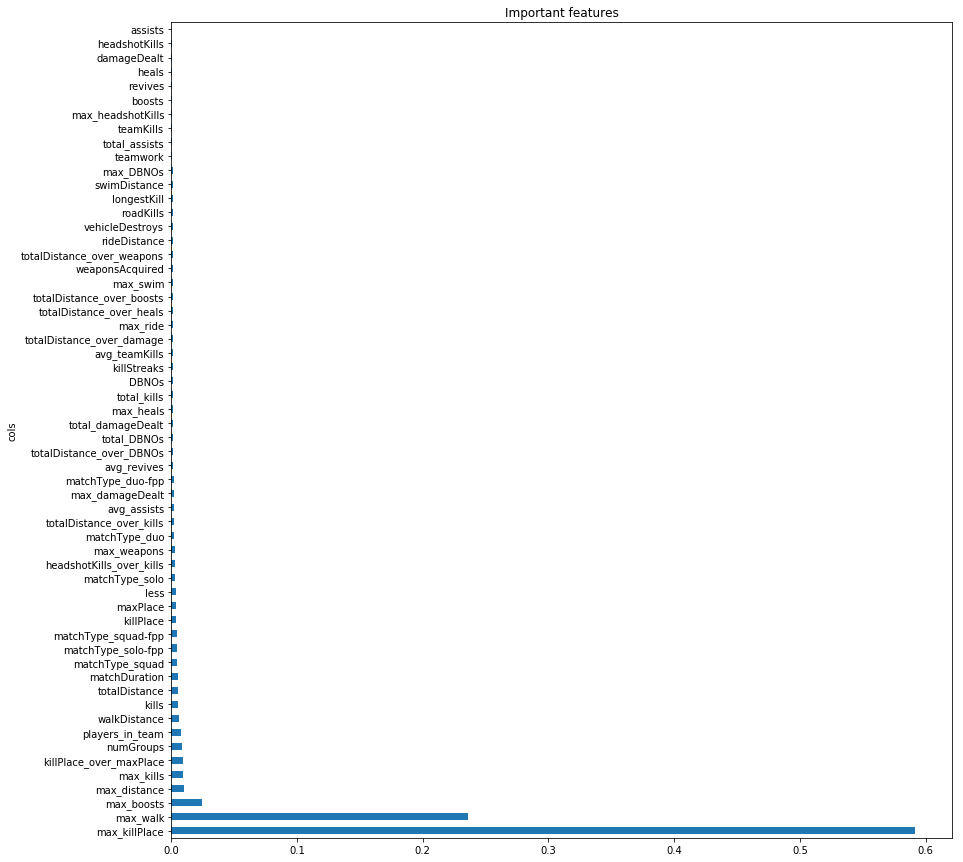

In [41]:
# What are the most predictive features according to our basic random forest model
fi = xgb_feat_importance(model, original)

# Plot a feature importance graph for the 20 most important features
fi.plot('cols', 'imp', figsize=(14,15), legend=False, kind = 'barh', title='Important features')